# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [03:39<00:00, 1656.09it/s]


In [23]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [02:30<00:00, 2418.28it/s]


# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [25]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [26]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('terrific', 0.8967643976211548), ('fantastic', 0.8951858878135681), ('awesome', 0.8659319281578064), ('good', 0.8604428768157959), ('excellent', 0.8569322824478149), ('wonderful', 0.8206120729446411), ('perfect', 0.7732004523277283), ('fabulous', 0.7684422731399536), ('nice', 0.7443358898162842), ('amazing', 0.7266738414764404)]
[('nastiest', 0.8660403490066528), ('greatest', 0.7526767253875732), ('disgusting', 0.752247154712677), ('horrid', 0.7259446978569031), ('terrible', 0.7123473882675171), ('saltiest', 0.7098361849784851), ('best', 0.7071012258529663), ('horrible', 0.691839337348938), ('awful', 0.6836269497871399), ('vile', 0.6789681911468506)]


In [27]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  33573
sample words  ['witty', 'little', 'book', 'makes', 'son', 'laugh', 'loud', 'recite', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'whales', 'india', 'drooping', 'roses', 'love', 'new', 'words', 'introduces', 'silliness', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'grew', 'reading', 'sendak', 'books', 'watching', 'really', 'rosie', 'movie', 'incorporates', 'loves', 'however', 'miss', 'hard', 'cover', 'version', 'seem', 'kind', 'flimsy', 'takes']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


In [25]:
# Function to plot confusion matrix
def confusion_matrix_plot(test_y, predict_y):
    # C stores the confusion matrix 
    C = confusion_matrix(test_y, predict_y)
    
    # Class labels 
    labels_x = ["Predicted No","Predicted Yes"]
    labels_y = ["Original No","Original Yes"]
    
    cmap=sns.light_palette("orange")
    print("Confusion matrix")
    plt.figure(figsize=(4,4))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_x, yticklabels=labels_y)
    plt.show()

In [26]:
# Function to plot roc curve

def plot_roc_curve(Y_test,predict_y_test,Y_train,predict_y_train):
    fpr1,tpr1,threshold1 = roc_curve(Y_test,predict_y_test) # For test dataset
    fpr2,tpr2,threshold2 = roc_curve(Y_train,predict_y_train) # For train dataset
    
    plt.plot([0,1],[0,1])
    plt.plot(fpr1,tpr1,label="Validation AUC")
    plt.plot(fpr2,tpr2,label="Train AUC")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

In [55]:
# Plotting graph of auc and parameter for training and cross validation error
import math
alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000] 
alpha1 = [math.log10(i) for i in alpha]
def plot_train_vs_auc(train_auc_list,cv_auc_list):
    plt.plot(alpha1,train_auc_list,label="Train AUC")
    plt.xlabel("Log of Hyper-parameter lambda for regularization")
    plt.ylabel("Area Under Curve")
    plt.plot(alpha1,cv_auc_list,label="Validation AUC")
    plt.legend()
    plt.show()

# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [97]:
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import TimeSeriesSplit
# intializing coount vectorizer
bow_vect = CountVectorizer()

X = preprocessed_reviews
Y = final['Score']

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)
print(len(X_train))

254919


In [98]:
# Vectorizing train and test dataset seperately
train_vect = bow_vect.fit_transform(X_train)
test_vect = bow_vect.transform(X_test)
train_vect.shape

(254919, 96683)

In [99]:
# Standarizing data
from sklearn.preprocessing import StandardScaler
train_vect = StandardScaler(with_mean=False).fit_transform(train_vect)
test_vect = StandardScaler(with_mean=False).fit_transform(test_vect)

In [100]:
# Initializing the logistice regression classifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from tqdm import tqdm  # this module is used to check the progress of loops
import numpy as np

param_lambda = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000] 
train_auc_list = [] # Will contain train auc score for various lambda

# Training and testing on train dataset
for i in tqdm(param_lambda):
    log_clf = LogisticRegression(penalty='l1',C=i,tol=0.1,n_jobs=4,max_iter=200)
    log_clf.fit(train_vect,Y_train)
    
    predict_probab = log_clf.predict_log_proba(train_vect)[:,1] # Returns log probability for positive class
    predict_probab = np.nan_to_num(predict_probab,copy=True)  # Tackles NaN and Infinite values
    auc = roc_auc_score(Y_train,predict_probab)
    train_auc_list.append(auc)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:44<00:00, 14.23s/it]


In [101]:
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

# In this section we will perform 5-fold Cross validation on timse series split data

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(param_lambda):
    # Naive bayes classifier
    clf = LogisticRegression(penalty='l1',C=i,tol=0.1,n_jobs=4,max_iter=200)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(train_vect):
        x_train = train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,predict_probab)
        
    cv_auc_list.append(auc/i) # Storing AUC value
        
        

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [11:36<00:00, 88.30s/it]


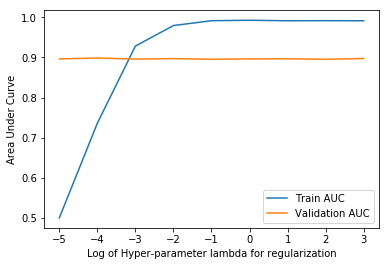

In [102]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [48]:
# Taking best value of lambda = 1 an trainig final model
# Initializing model
final_clf = LogisticRegression(penalty='l1',C=0.01,tol=0.1,n_jobs=4,max_iter=1000)

# Training final model
final_clf.fit(train_vect,Y_train)

predict_y = final_clf.predict(test_vect)
predict_probab = final_clf.predict_log_proba(test_vect)[:,1] # Returns probabality for positive points
predict_y_train = final_clf.predict(train_vect)
auc = roc_auc_score(Y_test,predict_probab)
print("Final AUC for BoW Logistic Regression is {:.3f}".format(auc))

Final AUC for BoW Logistic Regression is 0.949


Confusion Matrix for test data
Confusion matrix


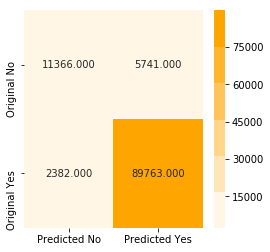

In [49]:
# Plotting confusion matrix
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y)

Confusion Matrix for Train data
Confusion matrix


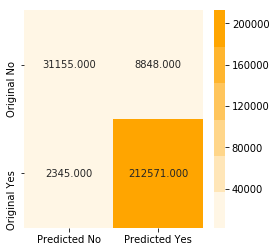

In [50]:
# Plotting confusion matrix
print("Confusion Matrix for Train data")
confusion_matrix_plot(Y_train,predict_y_train)

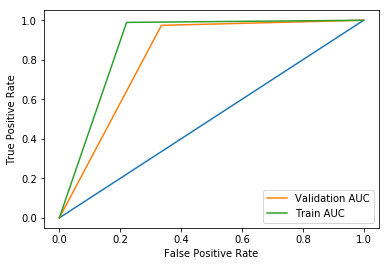

In [51]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = LogisticRegression(penalty='l1',C=i,tol=0.1,n_jobs=4,max_iter=400)
# Dictionary of parameters to be searched on 
parameters = {'C':[0.0001,0.001,0.01,0.1,1,10,100,1000]}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=10,refit=True,scoring=auc_score,n_jobs=4)

# Training the gridsearchcv instance
grid_model.fit(train_vect,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_

predict_probab = optimized_clf.predict_log_proba(test_vect)[:,1] # returns probability of positive points
predict_y = optimized_clf.predict(test_vect)
predict_y_train = optimized_clf.predict(train_vect)

print("AUC is {:.3f}".format(roc_auc_score(Y_test,predict_probab)))

AUC is 0.934


In [46]:
# Saving the best model
import pickle
outfile = open("log_reg_clf1","wb")
pickle.dump(optimized_clf,outfile)
outfile.close()

In [53]:
# Getting the best hyper-parameter of the trained model
best_param = grid_model.best_params_
print(best_param)

{'C': 0.1}


Confusion matrix


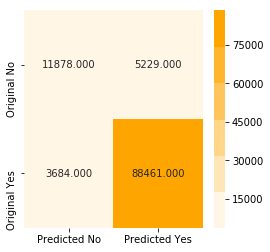

In [54]:
# Plotting confusion matrix
confusion_matrix_plot(Y_test,predict_y)

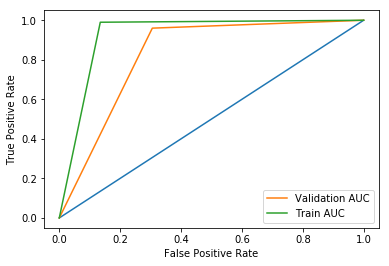

In [55]:
#Plotting ROC Curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [56]:
# Getting the weight vector from logistic regression classifier
weight_vect = final_clf.coef_
count = 0
for i in tqdm(range(len(weight_vect[0]))):
    if(weight_vect[0][i]==0):
        count += 1

print("count is",count)
print("Sparsity is",count/len(weight_vect[0]))


100%|████████████████████████████████████████████████████████████████████████| 96683/96683 [00:00<00:00, 604615.29it/s]

count is 79638
Sparsity is 0.823702202041724


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [103]:
# Training logistic regresison model and using L2 regularization.

train_auc_list = [] # Will contain train auc score for various lambda

param_lambda = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000] 

# Training and testing on train dataset
for i in tqdm(param_lambda):
    log_clf = LogisticRegression(penalty='l2',C=i,tol=0.1,n_jobs=4,max_iter=200)
    log_clf.fit(train_vect,Y_train)
    
    predict_probab = log_clf.predict_log_proba(train_vect)[:,1] # Returns log probability for positive class
    predict_probab = np.nan_to_num(predict_probab,copy=True)  # Tackles NaN and Infinite values
    
    auc = roc_auc_score(Y_train,predict_probab)
    train_auc_list.append(auc)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:04<00:00, 16.07s/it]


In [104]:
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

# In this section we will perform 10-fold Cross validation on timse series split data

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(param_lambda):
    # Naive bayes classifier
    clf = LogisticRegression(penalty='l2',C=k,tol=0.1,n_jobs=4,max_iter=200)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(train_vect):
        x_train = train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
        predict_probab = np.nan_to_num(predict_probab,copy=True)  # Tackles NaN and Infinite values
        i += 1
        auc += roc_auc_score(y_test,predict_probab)
        
    cv_auc_list.append(auc/i) # Storing AUC value

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [10:21<00:00, 89.53s/it]


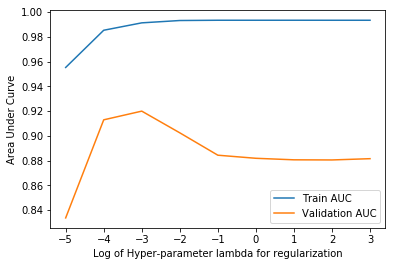

In [105]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [106]:
# Taking best value of alpha = 0.001 an trainig final model
# Initializing model
final_clf = LogisticRegression(penalty='l2',C=0.001,tol=0.1,n_jobs=4,max_iter=1000)

# Training final model
final_clf.fit(train_vect,Y_train)

predict_y = final_clf.predict(test_vect)
predict_probab = final_clf.predict_log_proba(test_vect)[:,1] # Returns probabality for positive points
predict_probab = np.nan_to_num(predict_probab,copy=True)  # Tackles NaN and Infinite values
predict_y_train = final_clf.predict(train_vect)
auc = roc_auc_score(Y_test,predict_probab)
print("Final AUC for BoW Logistic Regression is {:.3f}".format(auc))

Final AUC for BoW Logistic Regression is 0.931


Confusion Matrix for test data
Confusion matrix


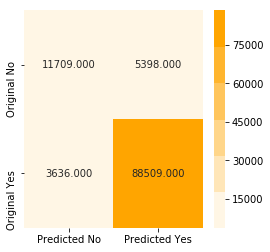

In [107]:
# Plotting confusion matrix for test data
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y)

Confusion Matrix for train data
Confusion matrix


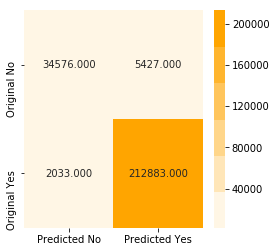

In [108]:
# Plotting confusion matrix for train data
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

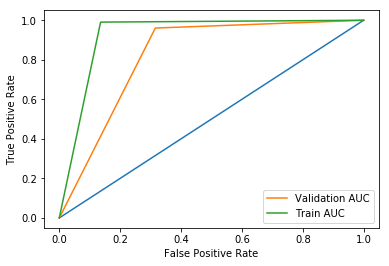

In [109]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

<h5>Hyper-parameter tunning using GridSearchCV</h5>

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = LogisticRegression(penalty='l2',tol=0.1,max_iter=400)

# Dictionary of parameters to be searched on 
parameters = {'C':[0.0001,0.001,0.01,0.1,1,10,100,1000]}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=10,refit=True,scoring=auc_score,n_jobs=4)

# Training the gridsearchcv instance
grid_model.fit(train_vect,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_

predict_probab = optimized_clf.predict_log_proba(test_vect)[:,1] # returns probability of positive points
predict_probab = np.nan_to_num(predict_probab,copy=True)  # Tackles NaN and Infinite values
predict_y = optimized_clf.predict(test_vect)
predict_y_train = optimized_clf.predict(train_vect)

print("AUC is {:.3f}".format(roc_auc_score(Y_test,predict_probab)))

AUC is 0.931


In [71]:
# Printing best parameter
print(grid_model.best_params_)

{'C': 0.001}


Confusion Matrix for test data
Confusion matrix


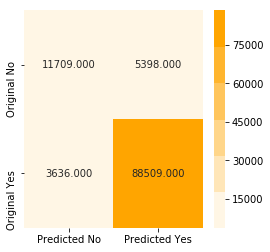

In [72]:
# Plotting confusion matrix for test data
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y)

Confusion Matrix for train data
Confusion matrix


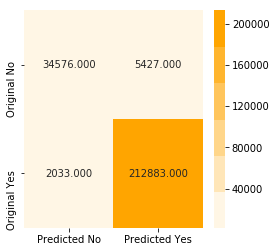

In [73]:
# Plotting confusion matrix for train data
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

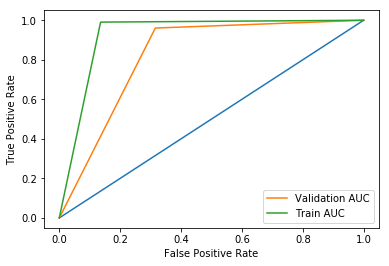

In [74]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [75]:

# Adding noise to train vect 
import copy
train_vect1 = copy.deepcopy(train_vect)

import numpy as np
e = np.random.normal(0,0.000001)

train_vect1.data = train_vect1.data + e  # Adding noise to train vector.
print(train_vect1.shape)

(254919, 96683)


In [76]:
# Training our model on new train_vect
# Taking best value of alpha = 1 an trainig final model
# Initializing model
noisy_clf = LogisticRegression(penalty='l1',C=0.01,tol=0.1,n_jobs=4,max_iter=1000)

# Training final model
noisy_clf.fit(train_vect1,Y_train)

noisy_weight_vect = noisy_clf.coef_

# To remove divide by zero error we are adding very small value to both weight vectors.
weight_vect = weight_vect + 0.000001
noisy_weight_vect = noisy_weight_vect + 0.000001

In [77]:
# Calculating percentage change in weight of noisy data w.r.t. original weight.
per_change = abs(((weight_vect - noisy_weight_vect)/weight_vect)) * 100
print("percentage change is",per_change)

percentage change is [[46456.77305308 38820.75078307     0.         ...     0.
      0.             0.        ]]


In [78]:
import math
# Sorting percentage change list for elbow method
sort_index = np.argsort(per_change[0])
print(sort_index)

sort_per_change = [math.log1p(abs(per_change[0][i])) for i in sort_index] # abs() is used to counter negative values

[48341 60687 60686 ... 52276 58024 16940]


In [79]:
# Calculating cumulative count of percentage change list.
# %change  count cumulative_count 
# 0.00       3         3
# 2.00       2      (3+2) = 5
# 2.50       5      (5+5) = 10
# and so on we calculate cumulative count of the number of values less than a particular percentage change.

cumu_lst = np.zeros(len(per_change[0])+1) # This contains n+1 values as for first entry 
                                          # cumu_lst[i+1] = cumu_list[i] + count  i starts from 0.
cumu_lst[0] = 0

for i in range(len(per_change[0])):
    count = 0
    for j in range(0,i):
        if(sort_per_change[i]>sort_per_change[j]):
            count += 1
            cumu_lst[i+1] = cumu_lst[i] + count


In [80]:
# Getting all the cumulative count in a list and scaling down large values to plot the grapg.
cumu_lst1 = [math.log1p(cumu_lst[i]) for i in range(1,len(cumu_lst))]
#print(len(cumu_lst1))

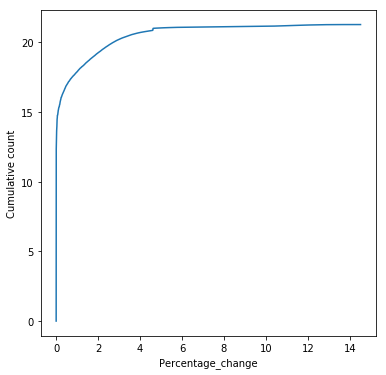

In [81]:
# Plotting graph of Percentage change Vs Cumualtive count.
# We will select that percentage change at which graph suddenly changes abruptly.

import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.plot(sort_per_change,cumu_lst1)
plt.xlabel("Percentage_change")
plt.ylabel("Cumulative count")
plt.show()

In [82]:
# Getting index of percentage change greater than the threshold change
# Threshold value of percentage change is 0.00% . This means we will remove features whose weight changed more than 0.0%.
per_change_index =[]
for i in tqdm(range(len(per_change[0]))):
    if(per_change[0][i]>0.0):
        per_change_index.append(i)

#print(len(per_change_index))



  0%|                                                                                        | 0/96683 [00:00<?, ?it/s]

 43%|███████████████████████████████                                         | 41745/96683 [00:00<00:00, 413556.70it/s]

100%|███████████████████████████████████████████████████████████████████████▋| 96328/96683 [00:00<00:00, 444953.01it/s]

100%|████████████████████████████████████████████████████████████████████████| 96683/96683 [00:00<00:00, 462860.79it/s]

In [83]:
# Getitng the name of features
multicolinear_features = []
all_features = bow_vect.get_feature_names()
for i in tqdm(per_change_index):
    multicolinear_features.append(all_features[i])

print(len(multicolinear_features))



  0%|                                                                                        | 0/19737 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████| 19737/19737 [00:00<00:00, 897755.99it/s]

19737


In [84]:
# printing multicollinear features
print(multicolinear_features)

['aa', 'aaa', 'aaaaa', 'aaaahhhhhh', 'aachen', 'aachener', 'aagh', 'aany', 'aardvark', 'aargh', 'aarrgh', 'aasanfood', 'aauces', 'ab', 'aback', 'abandoned', 'abated', 'abbie', 'abbondanza', 'abby', 'abc', 'abd', 'abel', 'abide', 'abietatered', 'able', 'abnormal', 'abortions', 'abouit', 'abound', 'aboutit', 'abouts', 'aboutthe', 'abouut', 'aboviously', 'abrading', 'abrasion', 'abrasive', 'abreast', 'abreva', 'abroad', 'abrooks', 'absentminded', 'absolute', 'absolutelt', 'absolutely', 'absoprtion', 'absoulutely', 'abstain', 'abstaining', 'absurd', 'absurdity', 'absurt', 'abt', 'abused', 'abuses', 'abusive', 'abut', 'abysmal', 'acaramel', 'accel', 'accelerade', 'acceleradetests', 'accelerated', 'acceptablebut', 'acceptence', 'accessory', 'accidenly', 'accident', 'accidently', 'acclimate', 'acclimates', 'accoding', 'accomplice', 'accomplishing', 'accomplishment', 'according', 'accountable', 'accounts', 'accoustomed', 'accpetable', 'acct', 'acctualy', 'accual', 'accumulating', 'accuracty', 

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [85]:
#To get most important features first sort the weight vectors in ascending order and then take last 10 features 
# Corresponding to that index.

top10_pos_feat = weight_vect[0].argsort() #Contains the index of all weights in descending order

# Top 10 features 
top10_pos_words = [all_features[i] for i in top10_pos_feat[-10:]]
print(top10_pos_words)

['wonderful', 'highly', 'loves', 'excellent', 'perfect', 'love', 'good', 'delicious', 'best', 'great']


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [86]:
#To get most important features first sort the weight vectors in ascending order and then take first 10 features 
# Corresponding to that index.

top10_neg_feat = weight_vect[0].argsort() #Contains the index of all weights in descending order

# Top 10 features 
top10_neg_words = [all_features[i] for i in top10_neg_feat[0:10]]
print(top10_neg_words)

['not', 'disappointed', 'worst', 'terrible', 'awful', 'money', 'disappointing', 'horrible', 'unfortunately', 'stale']


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [110]:
# Initializing Tfidf vectorizer 
tfidf_vect = TfidfVectorizer()

In [111]:
# Vectorizing train and test dataset seperately
train_vect = tfidf_vect.fit_transform(X_train)
test_vect = tfidf_vect.transform(X_test)
train_vect.shape

(254919, 96683)

In [112]:
# Standarizing data
train_vect = StandardScaler(with_mean=False).fit_transform(train_vect)
test_vect = StandardScaler(with_mean=False).fit_transform(test_vect)

In [113]:
# Initializing the logistice regression classifier

param_lambda = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000] 
train_auc_list = [] # Will contain train auc score for various lambda

# Training and testing on train dataset
for i in tqdm(param_lambda):
    log_clf = LogisticRegression(penalty='l1',C=i,tol=0.1,n_jobs=4,max_iter=200)
    log_clf.fit(train_vect,Y_train)
    
    predict_probab = log_clf.predict_log_proba(train_vect)[:,1] # Returns log probability for positive class
    auc = roc_auc_score(Y_train,predict_probab)
    train_auc_list.append(auc)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:35<00:00, 21.02s/it]


In [114]:
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

# In this section we will perform 10-fold Cross validation on timse series split data

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(param_lambda):
    # Naive bayes classifier
    clf = LogisticRegression(penalty='l1',C=k,tol=0.1,n_jobs=4,max_iter=400)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(train_vect):
        x_train = train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,predict_probab)
        
    cv_auc_list.append(auc/i) # Storing AUC value
        

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:42<00:00, 21.30s/it]


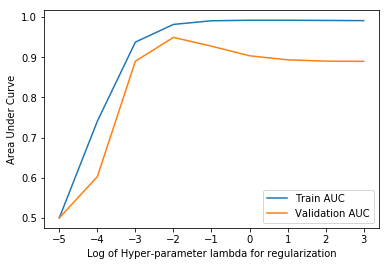

In [115]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [116]:
# Taking best value of lambda = 0.01 an trainig final model
# Initializing model
final_clf = LogisticRegression(penalty='l1',C=0.01,tol=0.1,n_jobs=4,max_iter=1000)

# Training final model
final_clf.fit(train_vect,Y_train)

predict_y = final_clf.predict(test_vect)
predict_probab = final_clf.predict_log_proba(test_vect)[:,1] # Returns probabality for positive points
predict_y_train = final_clf.predict(train_vect)
auc = roc_auc_score(Y_test,predict_probab)
print("Final AUC for Tfidf Logistic Regression is {:.3f}".format(auc))

Final AUC for Tfidf Logistic Regression is 0.957


Confusion Matrix for test data
Confusion matrix


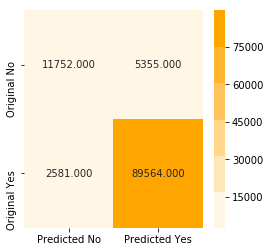

In [117]:
# Plotting confusion matrix for test data
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y)

Confusion Matrix for train data
Confusion matrix


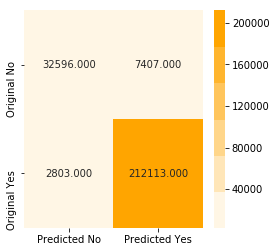

In [118]:
# Plotting confusion matrix for test data
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

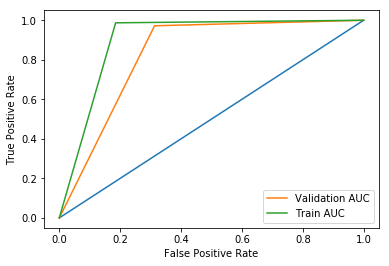

In [119]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

<h5>Hyper-parameter tunning using GridSearchCv</h5>

In [149]:
# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = LogisticRegression(penalty='l1',tol=0.1,n_jobs=4,max_iter=400)

# Dictionary of parameters to be searched on 
parameters = {'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=10,refit=True,scoring=auc_score,n_jobs=4)

# Training the gridsearchcv instance
grid_model.fit(train_vect,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_

predict_probab = optimized_clf.predict_log_proba(test_vect)[:,1] # returns probability of positive points
predict_y = optimized_clf.predict(test_vect)
predict_y_train = optimized_clf.predict(train_vect)

print("AUC is {:.3f}".format(roc_auc_score(Y_test,predict_probab)))

AUC is 0.957


In [150]:
# Getting the best paramater choosen by optimized_clf
print(grid_model.best_params_)

{'C': 0.01}


Confusion Matrix for test data
Confusion matrix


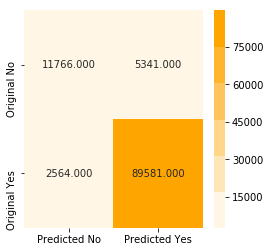

In [151]:
# Plotting confusion matrix for test data
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y)

Confusion Matrix for train data
Confusion matrix


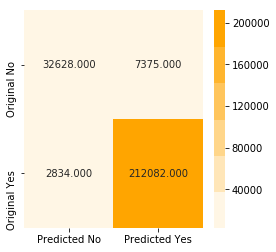

In [152]:
# Plotting confusion matrix for test data
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

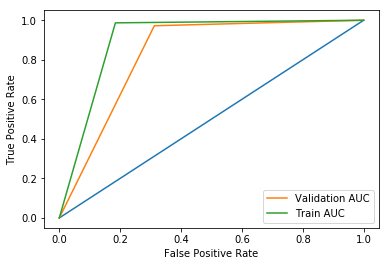

In [153]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [120]:
# Initializing the logistice regression classifier

param_lambda = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000] 
train_auc_list = [] # Will contain train auc score for various lambda

# Training and testing on train dataset
for i in tqdm(param_lambda):
    log_clf = LogisticRegression(penalty='l2',C=i,tol=0.1,n_jobs=4,max_iter=200)
    log_clf.fit(train_vect,Y_train)
    
    predict_probab = log_clf.predict_log_proba(train_vect)[:,1] # Returns log probability for positive class
    
    predict_probab = np.nan_to_num(predict_probab) # This replaces Nan and very large numbers.
    
    auc = roc_auc_score(Y_train,predict_probab)
    train_auc_list.append(auc)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:06<00:00,  7.90s/it]


In [121]:
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

# In this section we will perform 10-fold Cross validation on timse series split data

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(param_lambda):
    # Naive bayes classifier
    clf = LogisticRegression(penalty='l2',C=k,tol=0.1,n_jobs=4,max_iter=400)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(train_vect):
        x_train = train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
        predict_probab = np.nan_to_num(predict_probab) # This replaces Nan and very large numbers.
        
        i += 1
        auc += roc_auc_score(y_test,predict_probab)
        
    cv_auc_list.append(auc/i) # Storing AUC value
        

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [10:39<00:00, 84.20s/it]


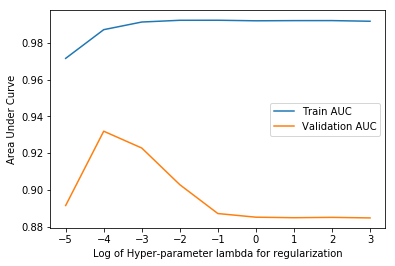

In [122]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [123]:
# Taking best value of lambda = 1 an trainig final model
# Initializing model
final_clf = LogisticRegression(penalty='l2',C=0.0001,tol=0.1,n_jobs=4,max_iter=1000)

# Training final model
final_clf.fit(train_vect,Y_train)

predict_y = final_clf.predict(test_vect)
predict_probab = final_clf.predict_log_proba(test_vect)[:,1] # Returns probabality for positive points
predict_y_train = final_clf.predict(train_vect)
auc = roc_auc_score(Y_test,predict_probab)
print("Final AUC for Tfidf Logistic Regression is {:.3f}".format(auc))

Final AUC for Tfidf Logistic Regression is 0.945


Confusion Matrix for test data
Confusion matrix


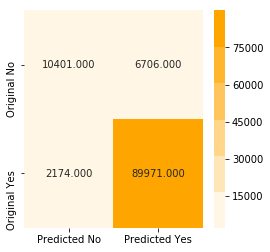

In [124]:
# Plotting confusion matrix for test data
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y)

Confusion Matrix for train data
Confusion matrix


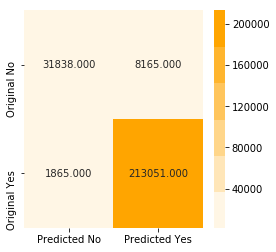

In [125]:
# Plotting confusion matrix for test data
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

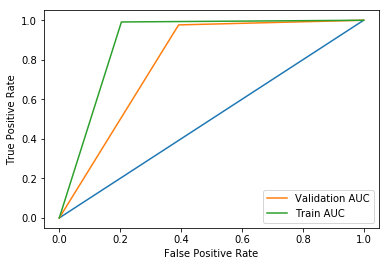

In [126]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

In [161]:
# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = LogisticRegression(penalty='l2',tol=0.1,n_jobs=4,max_iter=400)

# Dictionary of parameters to be searched on 
parameters = {'C':[0.0001,0.001,0.01,0.1,1,10,100,1000]}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=10,refit=True,scoring=auc_score,n_jobs=4)

# Training the gridsearchcv instance
grid_model.fit(train_vect,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_

predict_probab = optimized_clf.predict_log_proba(test_vect)[:,1] # returns probability of positive points
predict_y = optimized_clf.predict(test_vect)
predict_y_train = optimized_clf.predict(train_vect)

print("AUC is {:.3f}".format(roc_auc_score(Y_test,predict_probab)))

AUC is 0.937


In [162]:
# Printing best parameter
print(grid_model.best_params_)

{'C': 0.001}


Confusion Matrix for test data
Confusion matrix


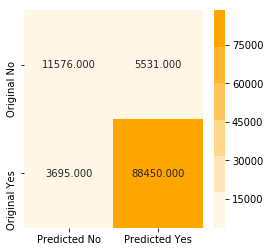

In [163]:
# Plotting confusion matrix for test data
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y)

Confusion Matrix for train data
Confusion matrix


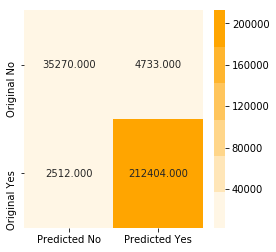

In [164]:
# Plotting confusion matrix for test data
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

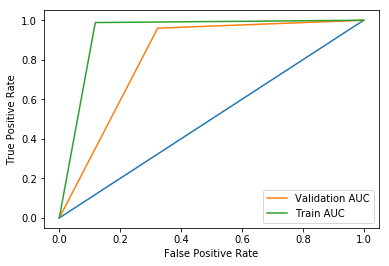

In [165]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [166]:
#To get most important features first sort the weight vectors in ascending order and then take last 10 features 
# Corresponding to that index.

weight_vect = final_clf.coef_ # Getting weight vectors.

all_features = tfidf_vect.get_feature_names()  # Getting all the feature names

top10_pos_feat = weight_vect[0].argsort() #Contains the index of all weights in descending order

# Top 10 features 
top10_pos_words = [all_features[i] for i in top10_pos_feat[-10:]]
print(top10_pos_words)

['nice', 'favorite', 'excellent', 'loves', 'perfect', 'delicious', 'good', 'love', 'best', 'great']


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [167]:
top10_pos_feat = weight_vect[0].argsort() #Contains the index of all weights in descending order

# Top 10 features 
top10_neg_words = [all_features[i] for i in top10_pos_feat[0:10]]
print(top10_neg_words)

['not', 'disappointed', 'worst', 'terrible', 'awful', 'disappointing', 'horrible', 'waste', 'unfortunately', 'stale']


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [68]:
# Splitting data into train and test dataset

X = list_of_sentance

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)

In [69]:
# average Word2Vec
# compute average word2vec for each review of training dataset

train_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_sent_vectors.append(sent_vec)
print(len(train_sent_vectors))
print(len(train_sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 254919/254919 [23:51<00:00, 178.12it/s]


254919
50


In [70]:
test_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_sent_vectors.append(sent_vec)
print(len(test_sent_vectors))
print(len(test_sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 109252/109252 [10:13<00:00, 178.20it/s]


109252
50


In [71]:
# Initializing the logistice regression classifier


param_lambda = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000] 
train_auc_list = [] # Will contain train auc score for various lambda

# Training and testing on train dataset
for i in tqdm(param_lambda):
    log_clf = LogisticRegression(penalty='l1',C=i,tol=0.1,n_jobs=4,max_iter=200)
    log_clf.fit(train_sent_vectors,Y_train)
    
    predict_probab = log_clf.predict_log_proba(train_sent_vectors)[:,1] # Returns log probability for positive class
    predict_probab = np.nan_to_num(predict_probab,copy=True)  # Tackles NaN and Infinite values
    auc = roc_auc_score(Y_train,predict_probab)
    train_auc_list.append(auc)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.10s/it]


In [72]:
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

# In this section we will perform 5-fold Cross validation on timse series split data

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(param_lambda):
    # Naive bayes classifier
    clf = LogisticRegression(penalty='l1',C=k,tol=0.1,n_jobs=4,max_iter=200)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(train_sent_vectors):
        x_train = train_sent_vectors[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = train_sent_vectors[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,predict_probab)
        
    cv_auc_list.append(auc/i) # Storing AUC value
        
        

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:08<00:00,  8.03s/it]


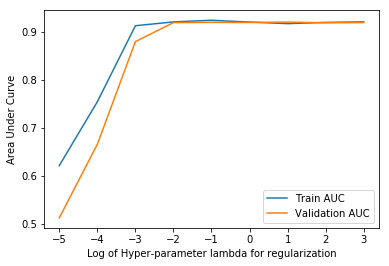

In [73]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [77]:
# Taking best value of lambda = 1 an trainig final model
# Initializing model
final_clf = LogisticRegression(penalty='l1',C=1,tol=0.1,n_jobs=4,max_iter=1000)

# Training final model
final_clf.fit(train_sent_vectors,Y_train)

predict_y = final_clf.predict(test_sent_vectors)
predict_probab = final_clf.predict_log_proba(test_sent_vectors)[:,1] # Returns probabality for positive points
predict_y_train = final_clf.predict(train_sent_vectors)
auc = roc_auc_score(Y_test,predict_probab)
print("Final AUC for BoW Logistic Regression is {:.3f}".format(auc))

Final AUC for BoW Logistic Regression is 0.920


Confusion Matrix for test data
Confusion matrix


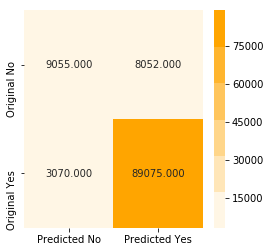

In [78]:
# Plotting confusion matrix for test data
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y)

Confusion Matrix for test data
Confusion matrix


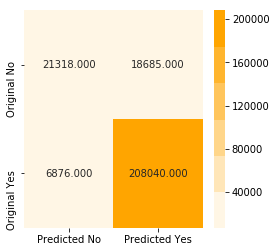

In [79]:
# Plotting confusion matrix for test data
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_train,predict_y_train)

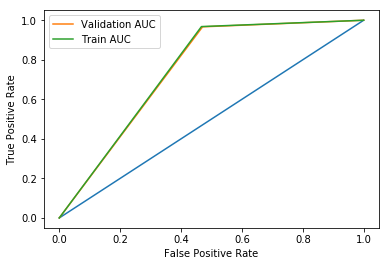

In [80]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

In [191]:
# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = LogisticRegression(penalty='l1',tol=0.1,n_jobs=4,max_iter=400)

# Dictionary of parameters to be searched on 
parameters = {'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=10,refit=True,scoring=auc_score,n_jobs=4)

# Training the gridsearchcv instance
grid_model.fit(train_sent_vectors,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_

predict_probab = optimized_clf.predict_log_proba(test_sent_vectors)[:,1] # returns probability of positive points
predict_y = optimized_clf.predict(test_sent_vectors)
predict_y_train = optimized_clf.predict(train_sent_vectors)

print("AUC is {:.3f}".format(roc_auc_score(Y_test,predict_probab)))

AUC is 0.917


In [192]:
# Printing best hyper-parameter
print(grid_model.best_params_)

{'C': 100}


Confusion Matrix for test data
Confusion matrix


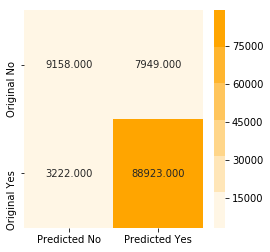

In [193]:
# Plotting confusion matrix for test data
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y)

Confusion Matrix for train data
Confusion matrix


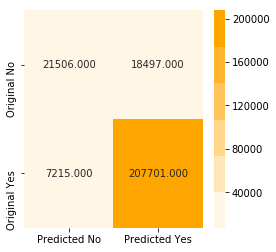

In [195]:
# Plotting confusion matrix for test data
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

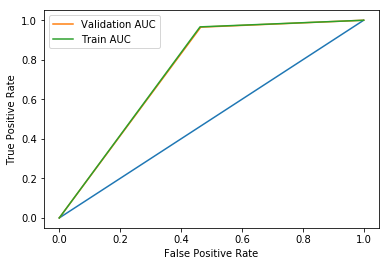

In [196]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [74]:
# Initializing the logistice regression classifier


param_lambda = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000] 
train_auc_list = [] # Will contain train auc score for various lambda

# Training and testing on train dataset
for i in tqdm(param_lambda):
    log_clf = LogisticRegression(penalty='l2',C=i,tol=0.1,n_jobs=4,max_iter=200)
    log_clf.fit(train_sent_vectors,Y_train)
    
    predict_probab = log_clf.predict_log_proba(train_sent_vectors)[:,1] # Returns log probability for positive class
    predict_probab = np.nan_to_num(predict_probab,copy=True)  # Tackles NaN and Infinite values
    auc = roc_auc_score(Y_train,predict_probab)
    train_auc_list.append(auc)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:25<00:00,  3.01s/it]


In [75]:
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

# In this section we will perform 5-fold Cross validation on timse series split data

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(param_lambda):
    # Naive bayes classifier
    clf = LogisticRegression(penalty='l2',C=k,tol=0.1,n_jobs=4,max_iter=200)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(train_sent_vectors):
        x_train = train_sent_vectors[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = train_sent_vectors[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,predict_probab)
        
    cv_auc_list.append(auc/i) # Storing AUC value
        

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:48<00:00, 13.09s/it]


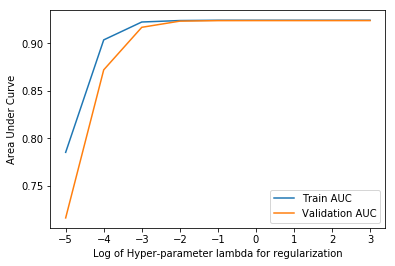

In [76]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [81]:
# Taking best value of lambda = 0.001 an trainig final model
# Initializing model
final_clf = LogisticRegression(penalty='l2',C=10,tol=0.1,n_jobs=4,max_iter=1000)

# Training final model
final_clf.fit(train_sent_vectors,Y_train)

predict_y = final_clf.predict(test_sent_vectors)
predict_probab = final_clf.predict_log_proba(test_sent_vectors)[:,1] # Returns probabality for positive points
predict_y_train = final_clf.predict(train_sent_vectors)
auc = roc_auc_score(Y_test,predict_probab)
print("Final AUC for Tfidf Logistic Regression is {:.3f}".format(auc))

Final AUC for Tfidf Logistic Regression is 0.923


Confusion Matrix for test data
Confusion matrix


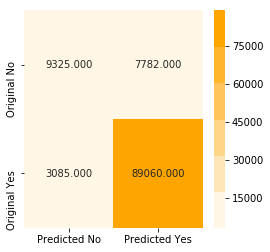

In [82]:
# Plotting confusion matrix for test data
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y)

Confusion Matrix for test data
Confusion matrix


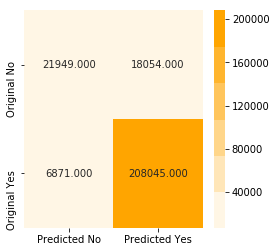

In [83]:
# Plotting confusion matrix for test data
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_train,predict_y_train)

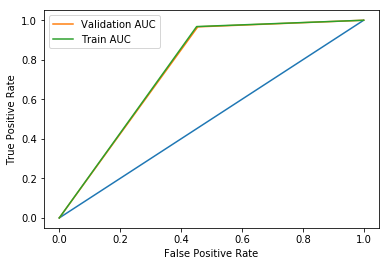

In [84]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

In [204]:
# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = LogisticRegression(penalty='l2',tol=0.1,n_jobs=4,max_iter=400)

# Dictionary of parameters to be searched on 
parameters = {'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=10,refit=True,scoring=auc_score,n_jobs=4)

# Training the gridsearchcv instance
grid_model.fit(train_sent_vectors,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_

predict_probab = optimized_clf.predict_log_proba(test_sent_vectors)[:,1] # returns probability of positive points
predict_y = optimized_clf.predict(test_sent_vectors)
predict_y_train = optimized_clf.predict(train_sent_vectors)

print("AUC is {:.3f}".format(roc_auc_score(Y_test,predict_probab)))

AUC is 0.924


In [205]:
# Printing best hyper-parameter
print(grid_model.best_params_)

{'C': 10}


Confusion Matrix for test data
Confusion matrix


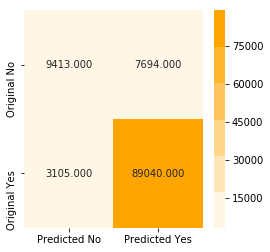

In [206]:
# Plotting confusion matrix for test data
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y)

Confusion Matrix for test data
Confusion matrix


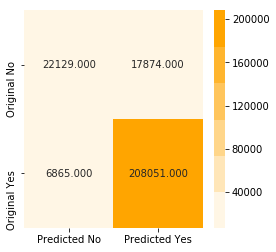

In [207]:
# Plotting confusion matrix for test data
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_train,predict_y_train)

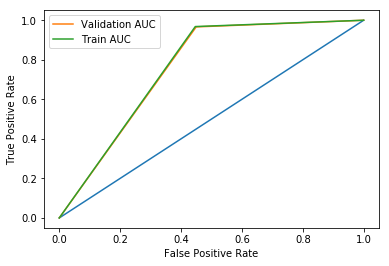

In [208]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [31]:
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from tqdm import tqdm  # this module is used to check the progress of loops
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

c:\users\rites\appdata\local\programs\python\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [32]:
# X_train contains sentences for training and X_test contains sentances for testing the model.
# Calculating TfidfW2V for X_train
Y = final['Score']

X_train,X_test,Y_train,Y_test = train_test_split(preprocessed_reviews,Y,test_size=0.3,random_state=42)

# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
train_model = TfidfVectorizer()
train_tfidf_matrix = train_model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
train_dictionary = dict(zip(train_model.get_feature_names(), list(train_model.idf_)))

In [33]:
# Calculating TfidfW2V for X_test

# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
test_model = TfidfVectorizer()
test_tfidf_matrix = test_model.fit_transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
test_dictionary = dict(zip(test_model.get_feature_names(), list(test_model.idf_)))

In [34]:
X_train,X_test,Y_train,Y_test = train_test_split(list_of_sentance,Y,test_size=0.3,random_state=42)

In [35]:
# TF-IDF weighted Word2Vec for X_train
train_tfidf_feat = train_model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review of X_train is stored in this list
row=0;
for sent in tqdm(X_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in train_tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf values of word in this review
            tf_idf = train_dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += 1
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████| 254919/254919 [8:13:32<00:00,  9.69it/s]


In [61]:
import pickle
outfile = open("train_tfidf_avg_w2v","wb")
pickle.dump(train_tfidf_sent_vectors,outfile)
outfile.close()

In [36]:
# TF-IDF weighted Word2Vec for X_test
test_tfidf_feat = test_model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review of X_train is stored in this list
row=0;
for sent in tqdm(X_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in test_tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = test_dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += 1
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████| 109252/109252 [2:22:05<00:00, 11.15it/s]


In [62]:
import pickle
outfile = open("test_tfidf_avg_w2v","wb")
pickle.dump(test_tfidf_sent_vectors,outfile)
outfile.close()

In [37]:
param_lambda = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000] 
train_auc_list = [] # Will contain train auc score for various lambda

# Training and testing on train dataset
for i in tqdm(param_lambda):
    log_clf = LogisticRegression(penalty='l1',C=i,tol=0.1,n_jobs=4,max_iter=200)
    log_clf.fit(train_tfidf_sent_vectors,Y_train)
    
    predict_probab = log_clf.predict_log_proba(train_tfidf_sent_vectors)[:,1] # Returns log probability for positive class
    predict_probab = np.nan_to_num(predict_probab,copy=True)  # Tackles NaN and Infinite values
    auc = roc_auc_score(Y_train,predict_probab)
    train_auc_list.append(auc)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.15s/it]


In [41]:
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

# In this section we will perform 5-fold Cross validation on timse series split data

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(param_lambda):
    # Naive bayes classifier
    clf = LogisticRegression(penalty='l1',C=k,tol=0.1,n_jobs=4,max_iter=200)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(train_tfidf_sent_vectors):
        x_train = train_tfidf_sent_vectors[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = train_tfidf_sent_vectors[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,predict_probab)
        
    cv_auc_list.append(auc/i) # Storing AUC value
        

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:02<00:00,  7.45s/it]


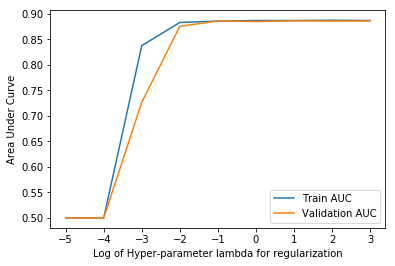

In [42]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [44]:
# Taking best value of lambda = 1 an trainig final model
# Initializing model
final_clf = LogisticRegression(penalty='l1',C=1,tol=0.1,n_jobs=4,max_iter=1000)

# Training final model
final_clf.fit(train_tfidf_sent_vectors,Y_train)

predict_y = final_clf.predict(test_tfidf_sent_vectors)
predict_probab = final_clf.predict_log_proba(test_tfidf_sent_vectors)[:,1] # Returns probabality for positive points
predict_y_train = final_clf.predict(train_tfidf_sent_vectors)
auc = roc_auc_score(Y_test,predict_probab)
print("Final AUC for Tfidf Logistic Regression is {:.3f}".format(auc))

Final AUC for Tfidf Logistic Regression is 0.887


Confusion Matrix for test data
Confusion matrix


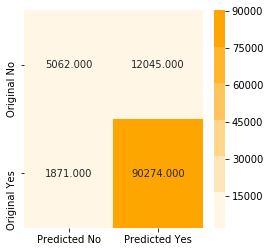

In [45]:
# Plotting confusion matrix for test data
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y)

Confusion Matrix for test data
Confusion matrix


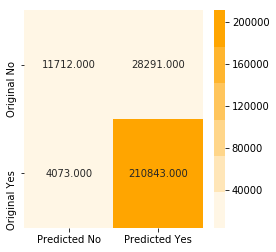

In [46]:
# Plotting confusion matrix for test data
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_train,predict_y_train)

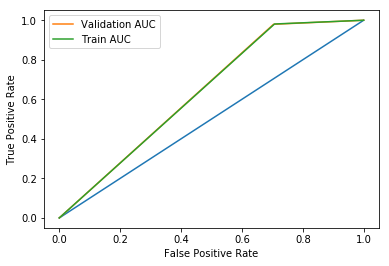

In [47]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

<h5>Hyper Paramater tuninng using GridSearchcv</h5>

In [56]:
# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = LogisticRegression(penalty='l1',tol=0.1,n_jobs=4,max_iter=400)

# Dictionary of parameters to be searched on 
parameters = {'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=10,refit=True,scoring=auc_score,n_jobs=4)

# Training the gridsearchcv instance
grid_model.fit(train_tfidf_sent_vectors,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_

predict_probab = optimized_clf.predict_log_proba(test_tfidf_sent_vectors)[:,1] # returns probability of positive points
predict_y = optimized_clf.predict(test_tfidf_sent_vectors)
predict_y_train = optimized_clf.predict(train_tfidf_sent_vectors)

print("AUC is {:.3f}".format(roc_auc_score(Y_test,predict_probab)))

AUC is 0.886


In [59]:
# Printing best parameter
print(grid_model.best_params_)

{'C': 100}


Confusion Matrix for test data
Confusion matrix


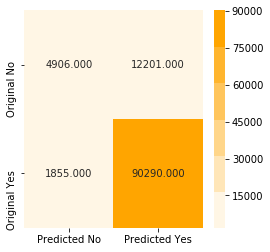

In [57]:
# Plotting confusion matrix for test data
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y)

Confusion Matrix for test data
Confusion matrix


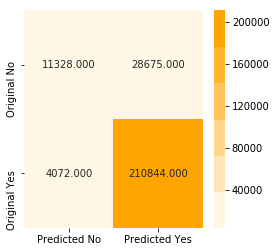

In [58]:
# Plotting confusion matrix for test data
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_train,predict_y_train)

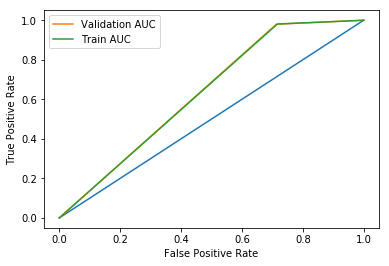

In [60]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [48]:
param_lambda = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000] 
train_auc_list = [] # Will contain train auc score for various lambda

# Training and testing on train dataset
for i in tqdm(param_lambda):
    log_clf = LogisticRegression(penalty='l2',C=i,tol=0.1,n_jobs=4,max_iter=200)
    log_clf.fit(train_tfidf_sent_vectors,Y_train)
    
    predict_probab = log_clf.predict_log_proba(train_tfidf_sent_vectors)[:,1] # Returns log probability for positive class
    predict_probab = np.nan_to_num(predict_probab,copy=True)  # Tackles NaN and Infinite values
    auc = roc_auc_score(Y_train,predict_probab)
    train_auc_list.append(auc)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:20<00:00,  2.36s/it]


In [49]:
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

# In this section we will perform 5-fold Cross validation on timse series split data

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(param_lambda):
    # Naive bayes classifier
    clf = LogisticRegression(penalty='l2',C=k,tol=0.1,n_jobs=4,max_iter=200)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(train_tfidf_sent_vectors):
        x_train = train_tfidf_sent_vectors[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = train_tfidf_sent_vectors[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,predict_probab)
        
    cv_auc_list.append(auc/i) # Storing AUC value

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:28<00:00, 10.45s/it]


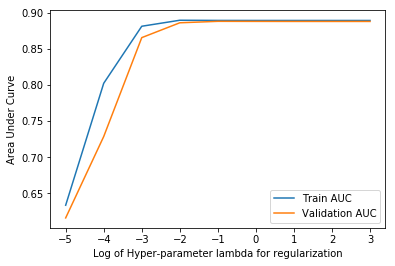

In [50]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [51]:
# Taking best value of lambda = 1 an trainig final model
# Initializing model
final_clf = LogisticRegression(penalty='l2',C=1,tol=0.1,n_jobs=4,max_iter=1000)

# Training final model
final_clf.fit(train_tfidf_sent_vectors,Y_train)

predict_y = final_clf.predict(test_tfidf_sent_vectors)
predict_probab = final_clf.predict_log_proba(test_tfidf_sent_vectors)[:,1] # Returns probabality for positive points
predict_y_train = final_clf.predict(train_tfidf_sent_vectors)
auc = roc_auc_score(Y_test,predict_probab)
print("Final AUC for Tfidf Logistic Regression is {:.3f}".format(auc))

Final AUC for Tfidf Logistic Regression is 0.888


Confusion Matrix for test data
Confusion matrix


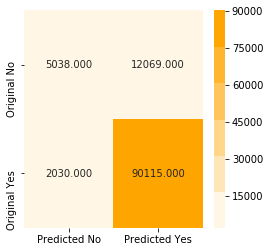

In [52]:
# Plotting confusion matrix for test data
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y)

Confusion Matrix for test data
Confusion matrix


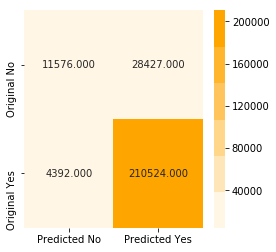

In [53]:
# Plotting confusion matrix for test data
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_train,predict_y_train)

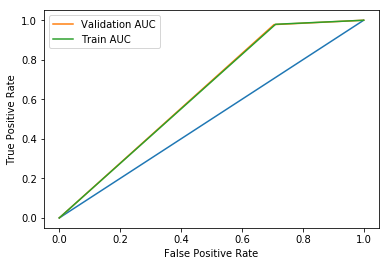

In [54]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

<h5>Hyper Parameter tuning using grid search</h5>

In [63]:
# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = LogisticRegression(penalty='l2',tol=0.1,n_jobs=4,max_iter=400)

# Dictionary of parameters to be searched on 
parameters = {'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=10,refit=True,scoring=auc_score,n_jobs=4)

# Training the gridsearchcv instance
grid_model.fit(train_tfidf_sent_vectors,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_

predict_probab = optimized_clf.predict_log_proba(test_tfidf_sent_vectors)[:,1] # returns probability of positive points
predict_y = optimized_clf.predict(test_tfidf_sent_vectors)
predict_y_train = optimized_clf.predict(train_tfidf_sent_vectors)

print("AUC is {:.3f}".format(roc_auc_score(Y_test,predict_probab)))

AUC is 0.888


Confusion Matrix for test data
Confusion matrix


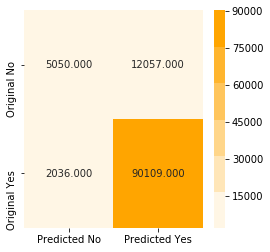

In [64]:
# Plotting confusion matrix for test data
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y)

Confusion Matrix for test data
Confusion matrix


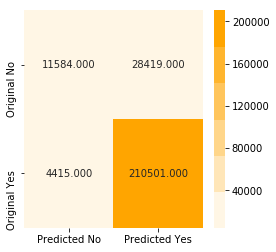

In [65]:
# Plotting confusion matrix for test data
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_train,predict_y_train)

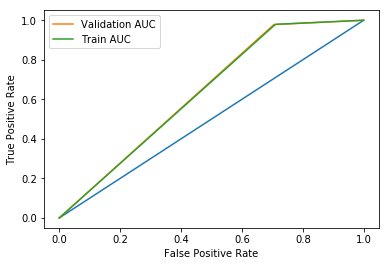

In [66]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

<h2>Feature engineering</h2>
<h4>Using review length as a feature</h4>

In [35]:
# Calculating and storing length of each review in train data set, in an numpy array

train_review_len = np.zeros(len(X_train))
i=0
for sent in X_train:
    train_review_len[i] = len(sent)
    i += 1

print(train_review_len.shape)

(254919,)


In [36]:
# Calculating and storing length of each review in train data set, in an numpy array

test_review_len = np.zeros(len(X_test))
i=0
for sent in X_test:
    test_review_len[i] = len(sent)
    i += 1

print(test_review_len.shape)

(109252,)


In [37]:
# vectorizing train and test dataset using bow
bow_train_vect = bow_vect.fit_transform(X_train)
bow_test_vect = bow_vect.transform(X_test)

In [38]:
from scipy.sparse import hstack
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix

# now we will add review length as a new feature to train  data set
# The shape of train_review_len is 254919 and hstack takes compatible matrices only 
# Making the train_review_len to bow_train_vect
A = coo_matrix([train_review_len]).T

bow_train_vect = hstack([bow_train_vect,A])
print(bow_train_vect.shape)

(254919, 96684)


In [39]:
# now we will add review length as a new feature to train  data set
# Since hstack takes compatible matrices only 
# Making the test_review_len to bow_test_vect
B = coo_matrix([test_review_len]).T
bow_test_vect = hstack([bow_test_vect,B])
print(bow_test_vect.shape)

(109252, 96684)


In [40]:
from scipy import sparse
# Converting bow_train_vect from scipy.sparse.coo.coo_matrix to scipy.sparse.csr.csr_matrix as 
# scipy.sparse.coo.coo_matrix are not subscriptable

bow_train_vect = sparse.csr_matrix(bow_train_vect)
print(type(bow_train_vect))

<class 'scipy.sparse.csr.csr_matrix'>


In [41]:
# Doing same as above for test dataset
bow_test_vect = sparse.csr_matrix(bow_test_vect)
print(type(bow_test_vect))

<class 'scipy.sparse.csr.csr_matrix'>


In [43]:
# Standarizing data
bow_train_vect = StandardScaler(with_mean=False).fit_transform(bow_train_vect)
bow_test_vect = StandardScaler(with_mean=False).fit_transform(bow_test_vect)

In [52]:
# In this section we will train naive bayes model and find training error for various alpha value
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from tqdm import tqdm  # this module is used to check the progress of loops
import numpy as np

param_lambda = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000] 
train_auc_list = [] # Will contain train auc score for various lambda

# Training and testing on train dataset
for i in tqdm(param_lambda):
    log_clf = LogisticRegression(penalty='l1',C=i,tol=0.1,n_jobs=4,max_iter=200)
    log_clf.fit(bow_train_vect,Y_train)
    
    predict_probab = log_clf.predict_log_proba(bow_train_vect)[:,1] # Returns log probability for positive class
    predict_probab = np.nan_to_num(predict_probab,copy=True)  # Tackles NaN and Infinite values
    auc = roc_auc_score(Y_train,predict_probab)
    train_auc_list.append(auc)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:47<00:00, 34.23s/it]


In [53]:
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

# In this section we will perform 5-fold Cross validation on timse series split data

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(param_lambda):
    # Naive bayes classifier
    clf = LogisticRegression(penalty='l1',C=i,tol=0.1,n_jobs=4,max_iter=200)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(bow_train_vect):
        x_train = bow_train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = bow_train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,predict_probab)
        
    cv_auc_list.append(auc/i) # Storing AUC value
        
        

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [06:59<00:00, 55.41s/it]


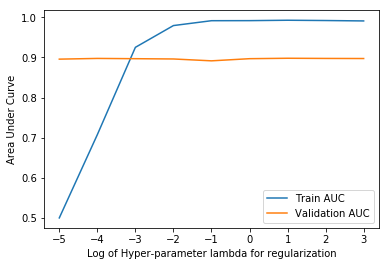

In [56]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [59]:
# Taking best value of lambda = 1 an trainig final model
# Initializing model
final_clf = LogisticRegression(penalty='l1',C=0.01,tol=0.1,n_jobs=4,max_iter=1000)

# Training final model
final_clf.fit(train_vect,Y_train)

predict_y = final_clf.predict(test_vect)
predict_probab = final_clf.predict_log_proba(test_vect)[:,1] # Returns probabality for positive points
predict_y_train = final_clf.predict(train_vect)
auc = roc_auc_score(Y_test,predict_probab)
print("Final AUC for BoW Logistic Regression is {:.3f}".format(auc))

Final AUC for BoW Logistic Regression is 0.949


Confusion Matrix for test data
Confusion matrix


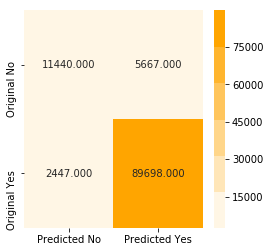

In [60]:
# Plotting confusion matrix for test data
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y)

Confusion Matrix for train data
Confusion matrix


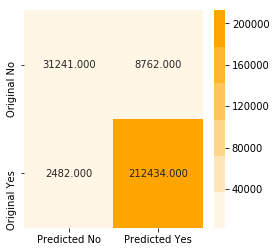

In [61]:
# Plotting confusion matrix for train data
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

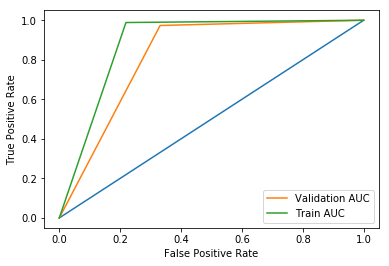

In [62]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

<h4>Using grid search CV</h4>

In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = LogisticRegression(penalty='l1',tol=0.1,n_jobs=4,max_iter=400)

# Dictionary of parameters to be searched on 
parameters = {'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=10,refit=True,scoring=auc_score,n_jobs=4)

# Training the gridsearchcv instance
grid_model.fit(bow_train_vect,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_

predict_probab = optimized_clf.predict_log_proba(bow_test_vect)[:,1] # returns probability of positive points
predict_y = optimized_clf.predict(bow_test_vect)
predict_y_train = optimized_clf.predict(bow_train_vect)

print("AUC is {:.3f}".format(roc_auc_score(Y_test,predict_probab)))

AUC is 0.931


In [65]:
# Printing best parameter selected by grid dearch
print(grid_model.best_params_)

{'C': 0.1}


Confusion Matrix for test data
Confusion matrix


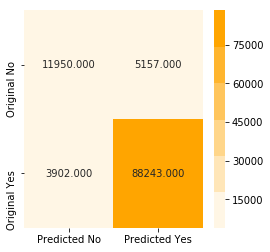

In [66]:
# Plotting confusion matrix for test data
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y)

Confusion Matrix for train data
Confusion matrix


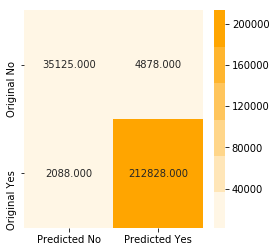

In [67]:
# Plotting confusion matrix for train data
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

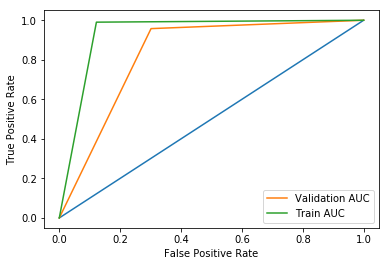

In [68]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

<h4>Using Summary as a feature</h4>

In [69]:
# Splitting summary into train and test 
train_summ,test_summ,Y_train_summ,Y_test_summ = train_test_split(preprocessed_summary,Y,test_size=0.3,random_state=42)

In [70]:
# Using bag of words to vectorize summary
# For train dataset
count_vect = CountVectorizer()
train_vect = count_vect.fit_transform(train_summ)
print(train_vect.shape)

# for test dataset
test_vect = count_vect.transform(test_summ)
print(test_vect.shape)

(254919, 26288)
(109252, 26288)


In [71]:
# now we will add vectorized review as a new feature to train data set
bow_train_vect = hstack([bow_train_vect,train_vect])
print(bow_train_vect.shape)

(254919, 122972)


In [72]:
# now we will add vectorized review as a new feature to train data set
bow_test_vect = hstack([bow_test_vect,test_vect])
print(bow_test_vect.shape)

(109252, 122972)


In [73]:
# Converting tfidf_train_vect and tfidf_test_vect from scipy.sparse.coo.coo_matrix to scipy.sparse.csr.csr_matrix as 
# scipy.sparse.coo.coo_matrix are not subscriptable

bow_train_vect = sparse.csr_matrix(bow_train_vect)
bow_test_vect = sparse.csr_matrix(bow_test_vect)
print(type(bow_train_vect))
print(type(bow_test_vect))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


In [74]:
# In this section we will train naive bayes model and find training error for various alpha value

param_lambda = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000] 
train_auc_list = [] # Will contain train auc score for various lambda

# Training and testing on train dataset
for i in tqdm(param_lambda):
    log_clf = LogisticRegression(penalty='l1',C=i,tol=0.1,n_jobs=4,max_iter=200)
    log_clf.fit(bow_train_vect,Y_train)
    
    predict_probab = log_clf.predict_log_proba(bow_train_vect)[:,1] # Returns log probability for positive class
    predict_probab = np.nan_to_num(predict_probab,copy=True)  # Tackles NaN and Infinite values
    auc = roc_auc_score(Y_train,predict_probab)
    train_auc_list.append(auc)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [06:13<00:00, 67.61s/it]


In [75]:
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

# In this section we will perform 5-fold Cross validation on timse series split data

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(param_lambda):
    # Naive bayes classifier
    clf = LogisticRegression(penalty='l1',C=i,tol=0.1,n_jobs=4,max_iter=200)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(bow_train_vect):
        x_train = bow_train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = bow_train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,predict_probab)
        
    cv_auc_list.append(auc/i) # Storing AUC value
        
        

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [17:37<00:00, 111.77s/it]


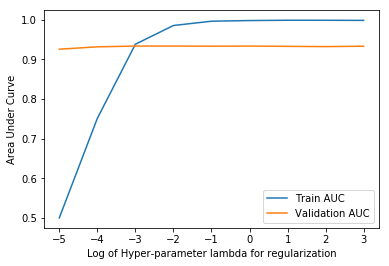

In [76]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [79]:
# Taking best value of lambda = 0.01 an trainig final model
# Initializing model
final_clf = LogisticRegression(penalty='l1',C=0.1,tol=0.1,n_jobs=4,max_iter=1000)

# Training final model
final_clf.fit(train_vect,Y_train)

predict_y = final_clf.predict(test_vect)
predict_probab = final_clf.predict_log_proba(test_vect)[:,1] # Returns probabality for positive points
predict_y_train = final_clf.predict(train_vect)
auc = roc_auc_score(Y_test,predict_probab)
print("Final AUC for BoW Logistic Regression is {:.3f}".format(auc))

Final AUC for BoW Logistic Regression is 0.928


Confusion Matrix for test data
Confusion matrix


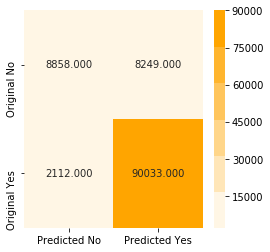

In [80]:
# Plotting confusion matrix for test data
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y)

Confusion Matrix for train data
Confusion matrix


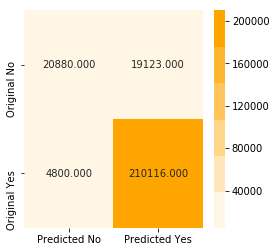

In [81]:
# Plotting confusion matrix for train data
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

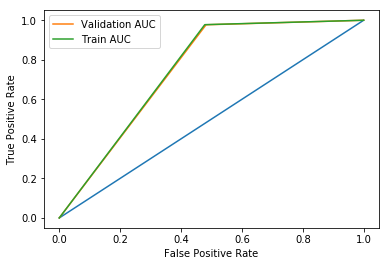

In [82]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

<h4>Using Grid Search</h4>

In [87]:
# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = LogisticRegression(penalty='l1',tol=0.1,n_jobs=4,max_iter=400)

# Dictionary of parameters to be searched on 
parameters = {'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=10,refit=True,scoring=auc_score,n_jobs=4)

# Training the gridsearchcv instance
grid_model.fit(bow_train_vect,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_

predict_probab = optimized_clf.predict_log_proba(bow_test_vect)[:,1] # returns probability of positive points
predict_y = optimized_clf.predict(bow_test_vect)
predict_y_train = optimized_clf.predict(bow_train_vect)

print("AUC is {:.3f}".format(roc_auc_score(Y_test,predict_probab)))

AUC is 0.953


In [88]:
# Printing best parameter selected by grid dearch
print(grid_model.best_params_)

{'C': 10}


Confusion Matrix for test data
Confusion matrix


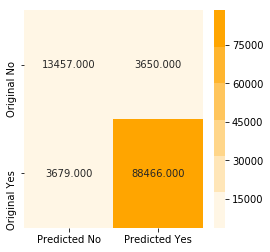

In [89]:
# Plotting confusion matrix for test data
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y)

Confusion Matrix for train data
Confusion matrix


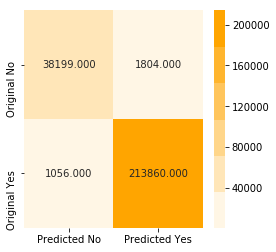

In [90]:
# Plotting confusion matrix for train data
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

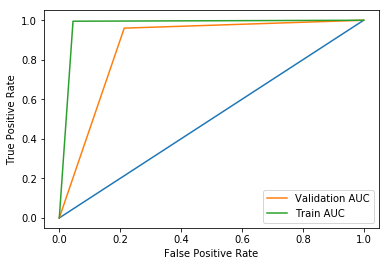

In [91]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

# [6] Conclusions

In [93]:
from prettytable import PrettyTable

# Initializing table object
x = PrettyTable()

x.field_names = ["Vectorizer","Model","Hyper-Parameter alpha","Area Under Curve"]

x.add_row([ "Bow","Logistic Regression L1 regularized","0.1","0.934" ])
x.add_row([ "Bow","Logistic Regression L2 regularized","0.001","0.931" ])
x.add_row([ "Tfidf","Logistic Regression L1 regularized","0.01","0.957" ])
x.add_row([ "Tfidf","Logistic Regression L2 regularized","0.001","0.937" ])
x.add_row([ "AvgW2V","Logistic Regression L1 regularized","100","0.917" ])
x.add_row([ "AvgW2V","Logistic Regression L2 regularized","10","0.924" ])
x.add_row([ "Tfidf weighted W2V","Logistic Regression L1 regularized","1.0","0.887" ])
x.add_row([ "Tfidf weighted W2V","Logistic Regression L2 regularized","1.0","0.888" ])
x.add_row([ "Bow with review length ","Logistic Regression L1 regularized","0.1","0.931" ])
x.add_row([ "Bow with summary feature","Logistic Regression L1 regularized","10","0.953" ])

print(x)

+--------------------------+------------------------------------+-----------------------+------------------+
|        Vectorizer        |               Model                | Hyper-Parameter alpha | Area Under Curve |
+--------------------------+------------------------------------+-----------------------+------------------+
|           Bow            | Logistic Regression L1 regularized |          0.1          |      0.934       |
|           Bow            | Logistic Regression L2 regularized |         0.001         |      0.931       |
|          Tfidf           | Logistic Regression L1 regularized |          0.01         |      0.957       |
|          Tfidf           | Logistic Regression L2 regularized |         0.001         |      0.937       |
|          AvgW2V          | Logistic Regression L1 regularized |          100          |      0.917       |
|          AvgW2V          | Logistic Regression L2 regularized |           10          |      0.924       |
|    Tfidf weighted

<h3>Explaination of results</h3>

<h5>Train data and test have been vectorized seperately to prevent data leak problem.</h5>
<h5>To tune hyper paarameter alpha custom 10-fold cross validation was done on Time Series Split data as reviews keeps changing with time. A graph was plotted to show train and validation AUC and best alpha was selected corresponding to best Validation AUC .</h5>
<h5>Best model was using the result of custom 10-fold cross validation and Grid Search .</h5>
<h5>To print top 10 features of positive class and negative class we did as follows:</h5>
<h5>We sorted the weight vectors using argsort in ascending order.</h5>
<h5>To print top 10 positive features we selected features corresponding to last 10 indexes from sorted index from above step.</h5>
<h5>To print top 10 negative features we selected features corresponding to last 10 indexes from sorted index from above step.</h5>
<h5>In feature engineering section we have used review length and summary as a feature along with review features.</h5>
<h5>We calculated length of each review and vectorized each sumomary and then combined these with reviews using hstack.</h5>
<h5>Out of all the models, BoW with summary feature had best performance along with having highest AUC of 0.953</h5>